In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

In [2]:
zip_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip",
    fname="jena_climate_2009_2016.csv.zip",
    extract=True)

13568290/13568290 [==============================] - 1s 0us/step


In [3]:
csv_path = "C:/Users/user/.keras/datasets/jena_climate_2009_2016.csv"

In [24]:
df = pd.read_csv(csv_path)
df = df[5::6]
date_time = pd.to_datetime(df.pop("Date Time"), format="%d.%m.%Y %H:%M:%S")

wv = df['wv (m/s)']
cond1 = (wv == -9999.0)
wv.loc[cond1] = 0.0
max_wv = df["max. wv (m/s)"]
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')
wd_rad = df.pop('wd (deg)')*np.pi / 180
df["Wx"] = wv * np.cos(wd_rad)
df["Wy"] = wv * np.sin(wd_rad)
df["max Wx"] = max_wv * np.cos(wd_rad)
df["max Wy"] = max_wv * np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day
df["Day sin"] = np.sin(timestamp_s * (2 * np.pi /day))
df["Day cos"] = np.cos(timestamp_s * (2 * np.pi /day))
df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))

column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [25]:
column_indices

{'p (mbar)': 0,
 'T (degC)': 1,
 'Tpot (K)': 2,
 'Tdew (degC)': 3,
 'rh (%)': 4,
 'VPmax (mbar)': 5,
 'VPact (mbar)': 6,
 'VPdef (mbar)': 7,
 'sh (g/kg)': 8,
 'H2OC (mmol/mol)': 9,
 'rho (g/m**3)': 10,
 'Wx': 11,
 'Wy': 12,
 'max Wx': 13,
 'max Wy': 14,
 'Day sin': 15,
 'Day cos': 16,
 'Year sin': 17,
 'Year cos': 18}

In [10]:
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

In [11]:
df.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [15]:
df.describe().transpose().loc[["wv (m/s)", "max. wv (m/s)"], "min"]

wv (m/s)        -9999.0
max. wv (m/s)   -9999.0
Name: min, dtype: float64

In [51]:
# 왜 내가 필사하면 w1 출력이 widnowgenerator만 나오는지 모르겠음.
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [55]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, 
               label_columns=["T (degC)"])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [60]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
               label_columns=["T (degC)"])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

- 핵심은 slicing 
> df[:, slice, :] 이해

In [57]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
        
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window

In [64]:
# (3, 7, 19) = (batch, timesteps, features)
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
         np.array(train_df[100: 100+w2.total_window_size]),
         np.array(train_df[200: 200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
Labels shape: (3, 1, 1)


In [65]:
w2.example = example_inputs, example_labels

In [70]:
def plot(self, model=None, plot_col="T (degC)", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10)
        
        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index
            
        
        if label_col_index is None:
            continue
            
        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                   edgecolors='k', label="Labels", c='#2ca02c', s=64)
        
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                       marker='X', edgecolor='k', label='Predictions',
                       c='#ff7f0e', s=64)
            
        if n==0:
            plt.legend()
            
    plt.xlabel('Time [h]')
    
WindowGenerator.plot = plot  

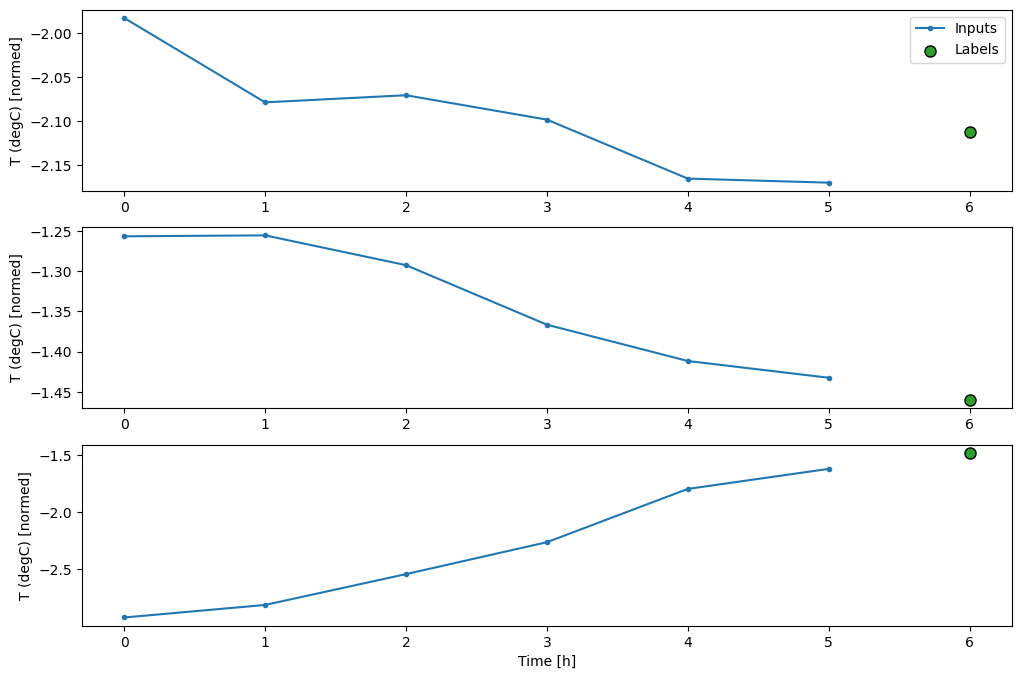

In [71]:
w2.plot()

In [74]:
#w2.plot(plot_col='p (mbar)')

## tf.data.Datasets

In [75]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32)
    
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset

In [76]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of 'inputs', 'labels' for plotting. """
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the '.train' dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [78]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [79]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


## single step models

model that predicts single features's value-1 time step

In [83]:
# produce these single-step (input, label) pairs:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=["T (degC)"])

In [84]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [85]:
# creates tf.data.Datasets from training set.
# it allows you to easily iterate over batches of data.
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


## baseline

first task: predict temperature on hour into the future, given the current value of all features. The current values include current temperature.

In [86]:
# bulid a model to predict 'T (degC)' value on hour into the future.
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [91]:
baseline = Baseline(label_index=column_indices['T (degC)'])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance["Baseline"] = baseline.evaluate(single_step_window.val)
performance["Baseline"] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 2ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


## wide window

In [93]:
# windows 24 hours cosecutive inputs and labels at a time
# the model will still make predictions 
# one hour into future based on a sigle input time step. 
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, 
                label_columns=["T (degC)"])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']

In [94]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


- blue `inputs` line: 
> shows the input temperature at each time step. The model receives all features, this plot only shows the temperature.

- green `Label` dots:
> show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step realtive to the inputs.

- Orange `Predictions` crosses: Show the model's predictionss for each ouput time step. If the model were predicting perfectly the  predictions would land directly on the `Labels`.

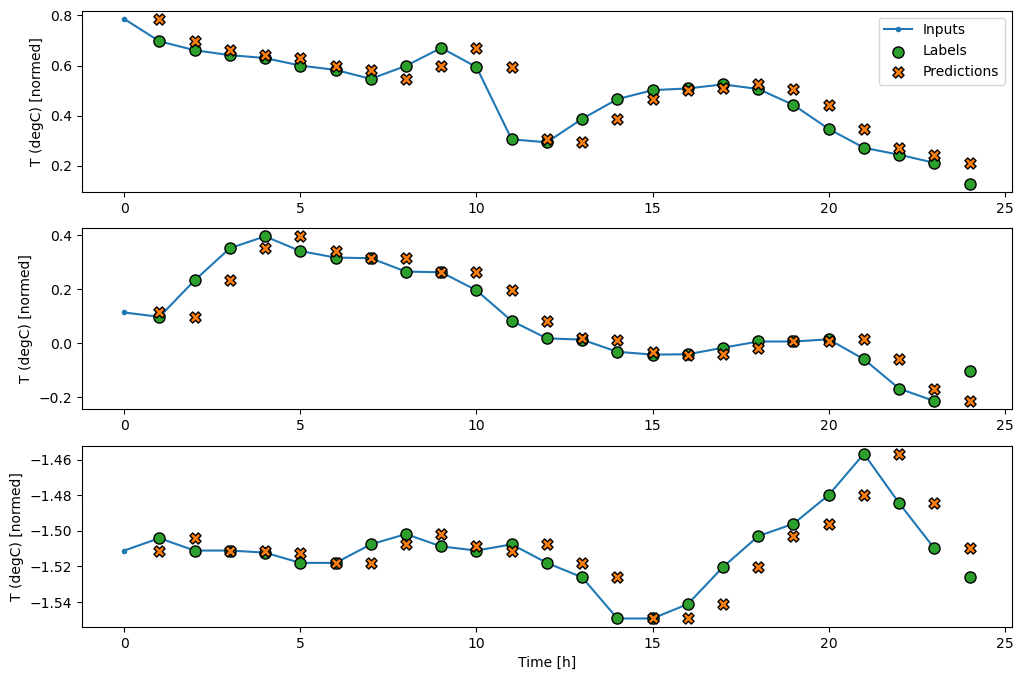

In [96]:
# plotting the baseline model's predictions
# Note that it is simply the labels shifted right by one hour:
wide_window.plot(baseline)

## Linear model

the simplest **trainable** model that can be applied to this task
> insert **linerar transformation**(A `tf.keras.layers.Dense` layer with no `activaiton`) between the input and output.

In [97]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [101]:
print('Input shape:', single_step_window.example[0].shape)
print('Ouput shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 19)
Ouput shape: (32, 1, 1)


## package the training procedure into a function:
since this tutorial trains many models 

In [104]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                     patience=patience,
                                                     mode='min')
    
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS,
             validation_data=window.val,
             callbacks=[early_stopping])
    
    return history

In [106]:
# Train the model and evaluate its performance:
history = compile_and_fit(linear, single_step_window)

val_performance["Linear"] = linear.evaluate(single_step_window.val)
performance["Linear"] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0702 - val_loss: 0.0088 - val_mean_absolute_error: 0.0691
Epoch 2/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0092 - mean_absolute_error: 0.0702 - val_loss: 0.0088 - val_mean_absolute_error: 0.0693
Epoch 3/20
439/439 [==============================] - 1s 1ms/step - loss: 0.0088 - mean_absolute_error: 0.0695


In [107]:
# 19가 24개있고 24개가 32개 있다.
print('Input shape: ', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape:  (32, 24, 19)
Output shape: (32, 24, 1)


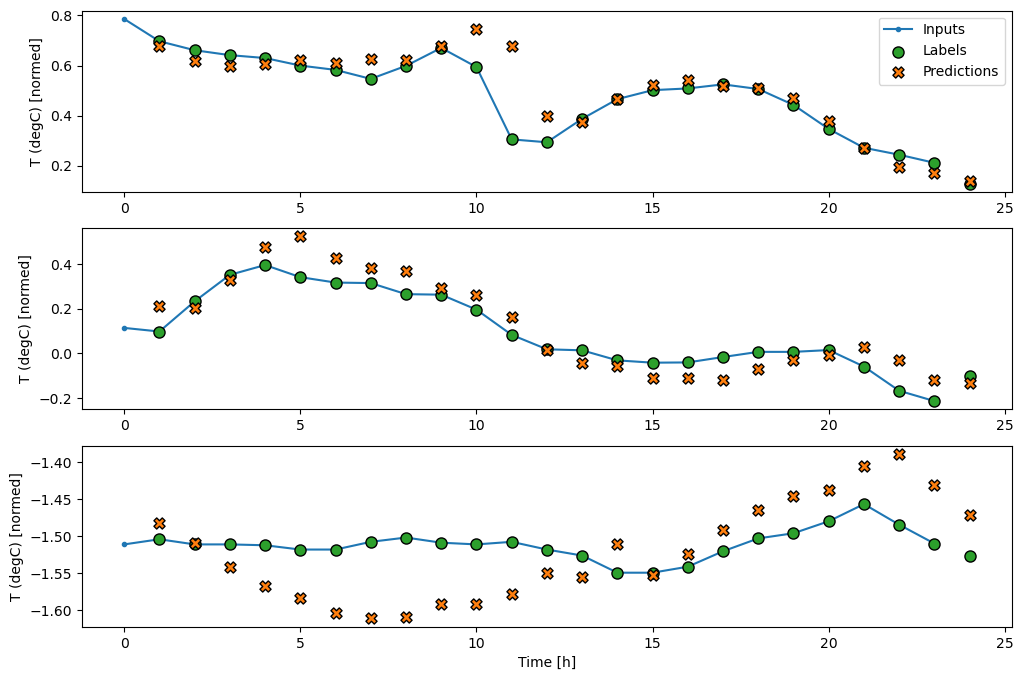

In [108]:
# plot predictions on the wide_window
# Note that how in many cases the predictions is clearly better than just returning the input temperature.
# But in few cases it's worse:
wide_window.plot(linear)
# 왼쪽 input 24개가 사용되지 않음
# 오른쪽 input 24개가 없음

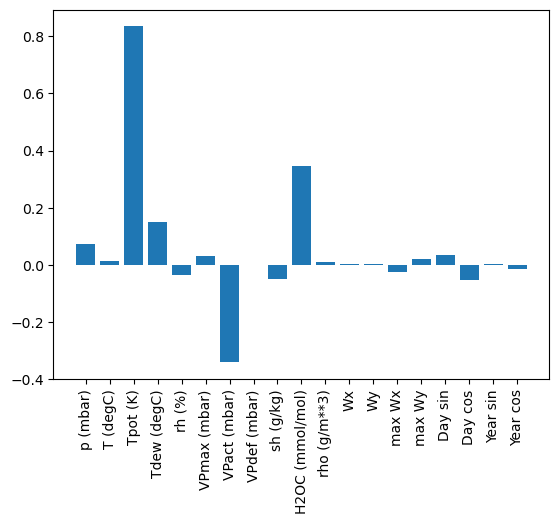

In [109]:
# Advantage of linear models: 
# They're relatively simple to interpret.
# e.g. You can pull out the layer's weights and
# visualize the weight assigned to each input:
plt.bar(x = range(len(train_df.columns)),
       height=linear.layers[0].kernel[:, 0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense

In [111]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=1)
])

In [113]:
history = compile_and_fit(dense, single_step_window)
val_performance["Dense"] = dense.evaluate(single_step_window.val)
performance["Dense"] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 4s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0578 - val_loss: 0.0065 - val_mean_absolute_error: 0.0576
Epoch 2/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0579 - val_loss: 0.0067 - val_mean_absolute_error: 0.0588
Epoch 3/20
439/439 [==============================] - 1s 1ms/step - loss: 0.0066 - mean_absolute_error: 0.0579


## multi-step dense
- above **single-step model** (baseline, linear, dense) has no context for the current values of its inputs.
- below **multi-step dense** can access to multiple time steps when making predictions:

In [114]:
# Create a WindowGenerator that will produce batches of three-hour inputs
# and one-hour labels:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=["T (degC)"])

In [115]:
# Note that Window's shift parameter is relative to the end of the two windows.
conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

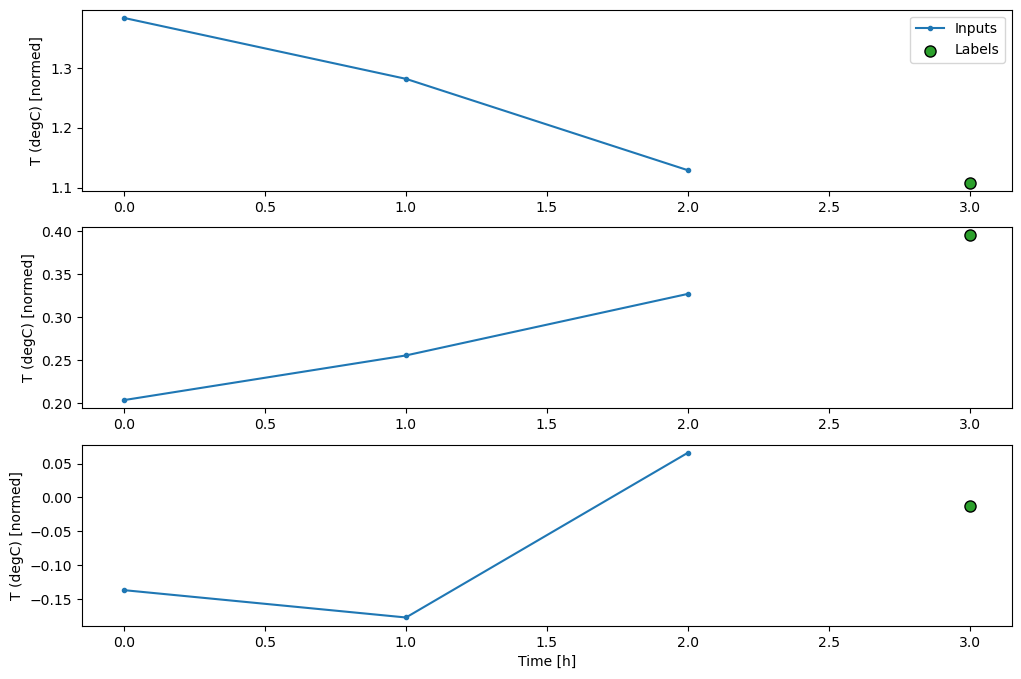

In [118]:
conv_window.plot()
#plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [119]:
# Train dense model on a multiple-input-step window
# by adding a tf.keras.layers.Flatten as the first layer of the model:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation="relu"), 
    tf.keras.layers.Dense(units=32, activation="relu"),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, -1])
])

In [121]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [122]:
import IPython
import IPython.display

In [124]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance["Multi step dense"] = multi_step_dense.evaluate(conv_window.val)
performance["Multi step dense"] = multi_step_dense.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 1s 1ms/step - loss: 0.0063 - mean_absolute_error: 0.0563


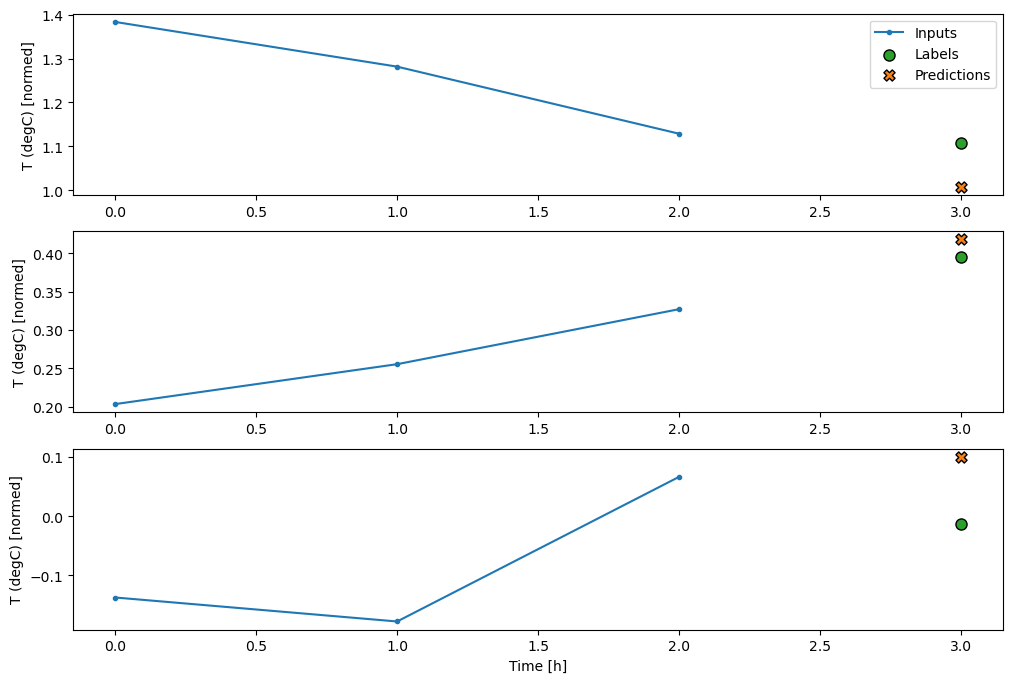

In [127]:
# main down-side: the resulting model can only be 
# executed on input windows of exactly this shape
conv_window.plot(multi_step_dense)

In [129]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

ValueError:Exception encountered when calling layer 'sequential_3' (type Sequential).

Input 0 of layer "dense_7" is incompatible with the layer: expected axis -1 of input shape to have value 57, but received input with shape (32, 456)

Call arguments received by layer 'sequential_3' (type Sequential):
  • inputs=tf.Tensor(shape=(32, 24, 19), dtype=float32)
  • training=None
  • mask=None


The convolutional models in the next sections fix this problem.